# RAG Chatbot

RAG chatbot, daha doğru ve bilgilendirici yanıtlar sağlamak için Retrieval-Augmented Generation (RAG) özelliğini kullanan bir sohbet robotu türüdür. RAG'ın temel fikri, büyük dil modellerinin yaratıcılığını ve bilgi üretme yeteneğini, gerçek dünya verileriyle desteklemektir. Büyük dil modellerinin gücünü bir veri tabanına erişimle birleştirerek ilgili bilgilerin çağırılmasını ve insan benzeri metin yanıtları üretmesini sağlar. Bu yaklaşım, sohbet robotunun karmaşık sorguları yanıtlama ve spesifik konularla ilgili bilgiler sağlama yeteneğini geliştirir.


**LangChain, farklı belge türlerine uyarlanmış çeşitli belge yükleyicileri sağlar.** İşte bazı örnekler:

**PDF'ler:** PDF belgelerini yüklemek için PyPDFLoader, PDFPlumber veya PyMuPDF gibi yükleyicileri kullanılır.

**CSV Dosyaları:** CSV dosyalarını yüklemek için CSVLoader kullanılır.

**Web Sayfaları:** Web sayfalarından HTML içeriği yüklemek için WebLoader veya Unstructured gibi yükleyicileri kullanılır.

**Sosyal Medya:** TwitterTweetLoader ve RedditPostsLoader'ı kullanarak Twitter ve Reddit gibi platformlardan veri yüklenir.

**Mesajlaşma Hizmetleri:** WhatsAppChatLoader ve DiscordChatLoader ile WhatsApp ve Discord gibi platformlar için yükleyicileri kullanılır.

https://python.langchain.com/docs/integrations/document_loaders/

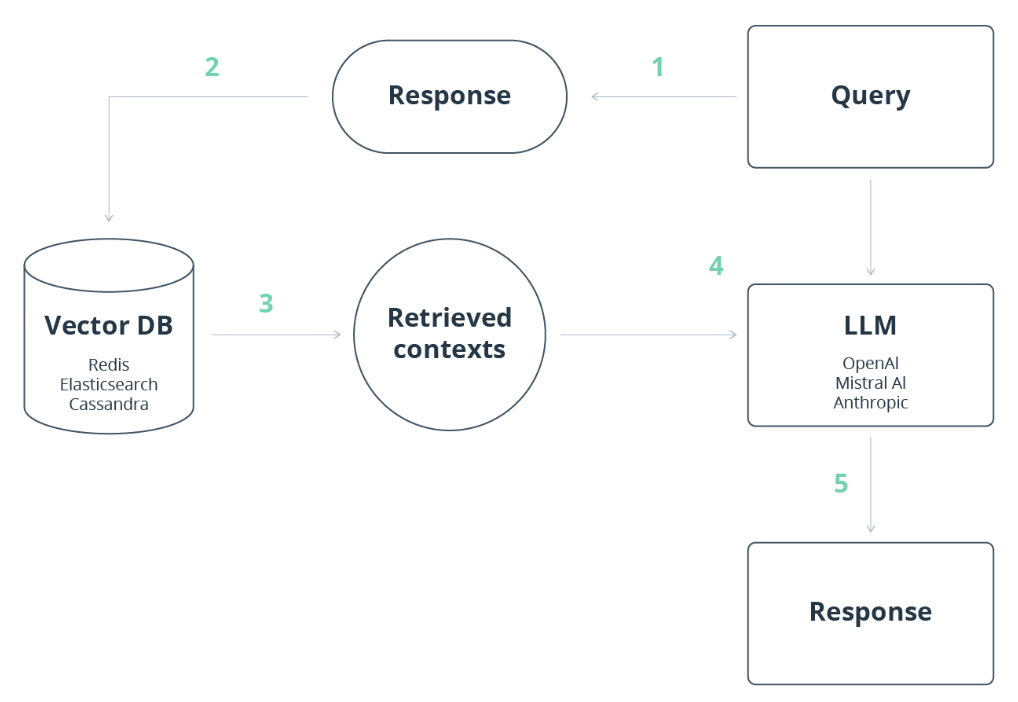

Faydalı linkler:

https://chat.langchain.com/

https://python.langchain.com/docs/how_to/vectorstores/

https://python.langchain.com/docs/how_to/#document-loaders

https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.base.Runnable.html


In [1]:
from dotenv import load_dotenv

load_dotenv()

False

In [2]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

In [6]:


loader = PDFPlumberLoader("Daily_Dose_Of_Data_Science_Full_Archive.pdf")

# Load the document
documents = loader.load()

#splitting the text into
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
texts = text_splitter.split_documents(documents)

print(f"created {len(texts)} chunks")


created 611 chunks


In [7]:
#embedding the texts
model_name = "BAAI/bge-base-en"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
    encode_kwargs=encode_kwargs
)

/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
#creating the vectorstore
persist_directory = 'db'

vectordb = Chroma.from_documents(documents=texts,
                                 collection_name="rag-chroma",
                                 embedding=bge_embeddings,
                                 persist_directory=persist_directory)
retriever = vectordb.as_retriever()

In [9]:
#Testing the vectorstore
query = "What is the role of data scientist?"
results = retriever.get_relevant_documents(query)
print(results[0].page_content)

DailyDoseofDS.com
 h   p  k 
While tabular data space is mainly dominated by Pandas and Sklearn, one can
hardly expect any benefit from them beyond some GBs of data due to their
single-node processing.
A more practical solution is to use distributed computing instead — a framework
that disperses the data across many small computers.
Spark is among the best technologies used to quickly and efficiently analyze,
process, and train models on big datasets.
That is why most data science roles at big tech demand proficiency in Spark. It’s
that important
432


In [10]:
#Testing the vectorstore
query = "What is the role of data scientist?"
results = retriever.get_relevant_documents(query)
for result in results:
    print(result.page_content)  

DailyDoseofDS.com
 h   p  k 
While tabular data space is mainly dominated by Pandas and Sklearn, one can
hardly expect any benefit from them beyond some GBs of data due to their
single-node processing.
A more practical solution is to use distributed computing instead — a framework
that disperses the data across many small computers.
Spark is among the best technologies used to quickly and efficiently analyze,
process, and train models on big datasets.
That is why most data science roles at big tech demand proficiency in Spark. It’s
that important
432
DailyDoseofDS.com
 h   p  k 
While tabular data space is mainly dominated by Pandas and Sklearn, one can
hardly expect any benefit from them beyond some GBs of data due to their
single-node processing.
A more practical solution is to use distributed computing instead — a framework
that disperses the data across many small computers.
Spark is among the best technologies used to quickly and efficiently analyze,
process, and train models on b

In [11]:
# alternative method to get the results
results1 = retriever.invoke(query)
for result in results1:
    print(result.page_content)

DailyDoseofDS.com
 h   p  k 
While tabular data space is mainly dominated by Pandas and Sklearn, one can
hardly expect any benefit from them beyond some GBs of data due to their
single-node processing.
A more practical solution is to use distributed computing instead — a framework
that disperses the data across many small computers.
Spark is among the best technologies used to quickly and efficiently analyze,
process, and train models on big datasets.
That is why most data science roles at big tech demand proficiency in Spark. It’s
that important
432
DailyDoseofDS.com
 h   p  k 
While tabular data space is mainly dominated by Pandas and Sklearn, one can
hardly expect any benefit from them beyond some GBs of data due to their
single-node processing.
A more practical solution is to use distributed computing instead — a framework
that disperses the data across many small computers.
Spark is among the best technologies used to quickly and efficiently analyze,
process, and train models on b

In [16]:
from langchain_openai import ChatOpenAI

In [17]:

from langchain_core.runnables import RunnableLambda

# Wrap the prompt in a function
def prompt_fn(query: str, context: str) -> str:
    return f"You are a knowledgeable learning assistant. Your users are asking questions about educational materials such as lecture notes, textbooks, or articles. Answer the user's question using only the given context. If you don't know the answer, just say you don't know. Use up to three sentences and be concise in your response.\n\nContext: {context}\n\nUser's question: {query}"

prompt_runnable = RunnableLambda(lambda inputs: prompt_fn(inputs["query"], inputs["context"]))


# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Define the chain using the wrapped prompt
rag_chain = prompt_runnable | llm | StrOutputParser()

ValidationError: 1 validation error for ChatOpenAI
__root__
  Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. (type=value_error)

In [13]:
def generate_response(query):
    # Retrieve relevant documents
    results = retriever.get_relevant_documents(query)
    context = "\n".join([doc.page_content for doc in results])
    
    # Pass the query and context to the chain
    inputs = {"query": query, "context": context}
    response = rag_chain.invoke(inputs)
    
    return response


In [15]:
query = "What is the role of data scientist?"
print(generate_response(query))

NameError: name 'rag_chain' is not defined